# Model creation

This notebook covers the steps necessary to create eclipse models from the lightcurves we generated in data_processing.

In [11]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import lightkurve as lk
from astropy.table import Table
from pathlib import Path
from astropy.coordinates import SkyCoord
from astroquery.mast import Catalogs
import pandas as pd
from astropy.table import vstack
from astropy.time import Time
from astropy.coordinates import EarthLocation
import astropy.units as u
import re
from glob import glob
from astropy.stats import sigma_clip
from PyAstronomy.pyTiming import pyPDM
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy.signal import correlate
from scipy.signal import medfilt
from PyAstronomy.pyTiming import pyPDM
from scipy.optimize import curve_fit
from statsmodels.nonparametric.smoothers_lowess import lowess
from joblib import Parallel, delayed
from tqdm import tqdm
import os
from scipy.optimize import least_squares

Before we start creating our models, we need to load in our lightcurves that we created earlier.

In [12]:
# Read in our lightcurves
lightcurves = []
files = glob("Data/combined_lightcurves/*.csv")

for f in files:
    lc = Table.read(f, format='csv')
    lightcurves.append(lc)  

Note when we create our models, we want to only use the highest quality data, as we will be creating our models by fitting to our data. If there is excess noise/poor sampling, our eclipse models may not be representative of the true eclipse. As such, when we fit our eclipses, we filter to only include the TESS data.

This does introduce a bias against changing eclipse shapes though. If an eclipse's shape evolves over a baseline longer than the TESS observations, our models may not be representative of archival eclipses.

In [13]:
# Mask our lightcurves to only include TESS data to help with model fitting and MET finding.
lightcurves_tess = []
for lc in lightcurves:
    lc_tess = lc[lc['source'] == 'TESS']
    lightcurves_tess.append(lc)

For each source that we want to look at, we need to create a model for both the primary and secondary eclipses. We create these models by masking our lightcurves in phase space and fitting a LOWESS function to them. We also ensure that the models are symmetrical. The functions to create these models are found below alongside an example.

0


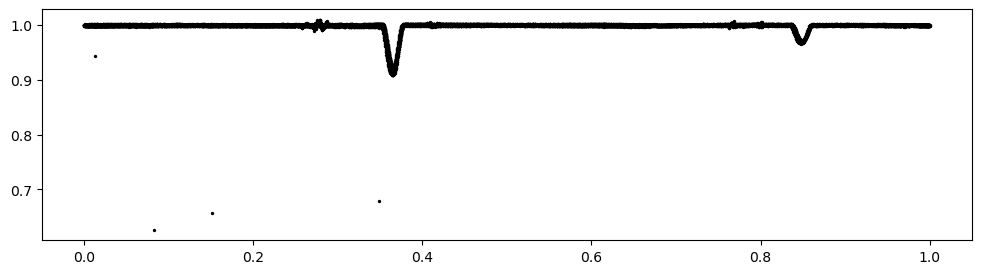

1


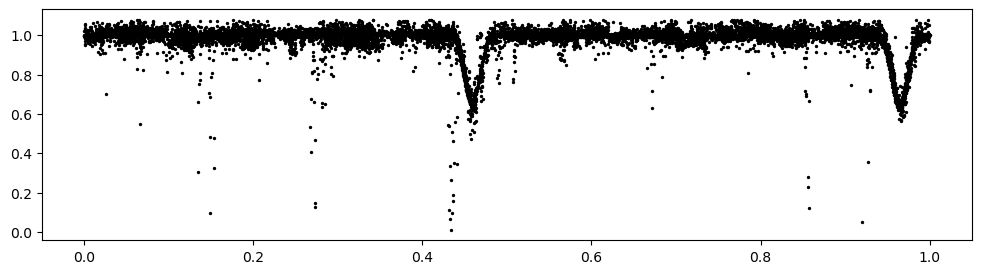

2


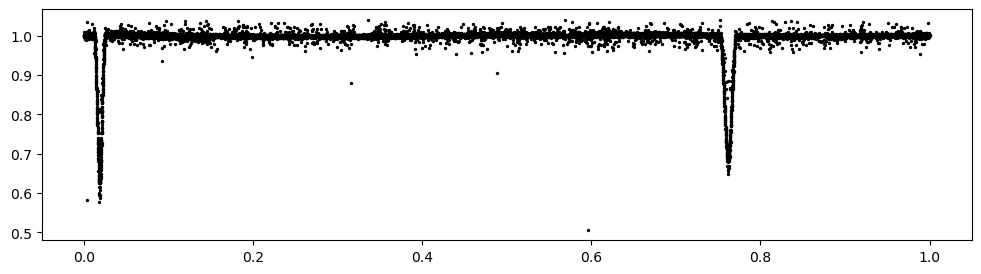

3


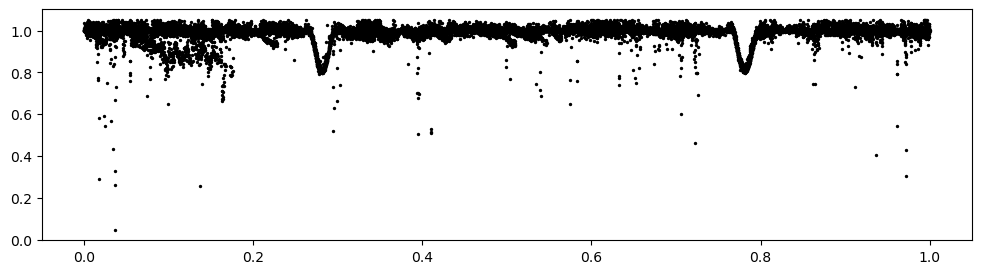

4


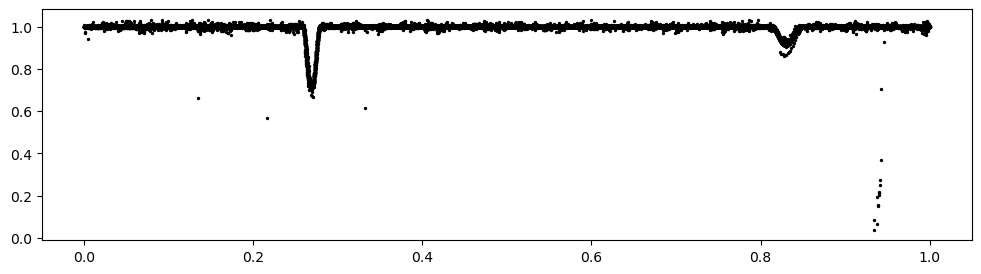

5


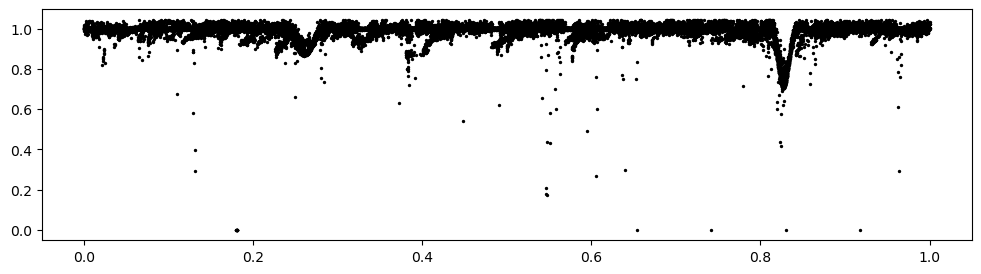

6


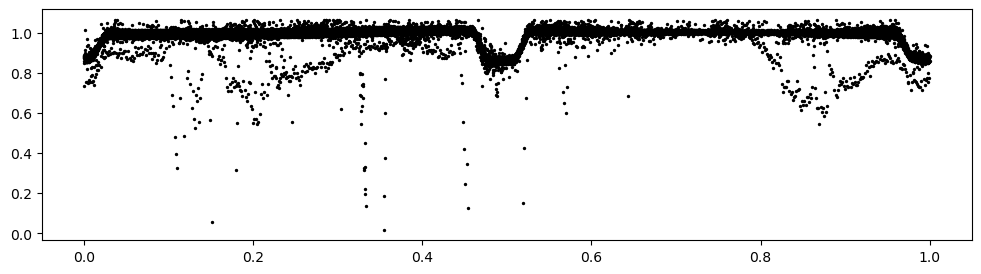

7


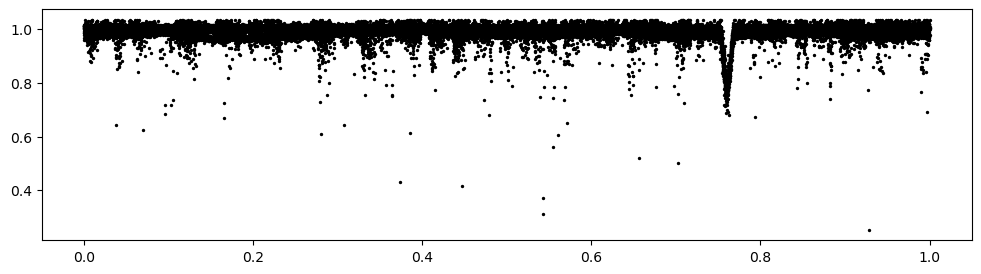

8


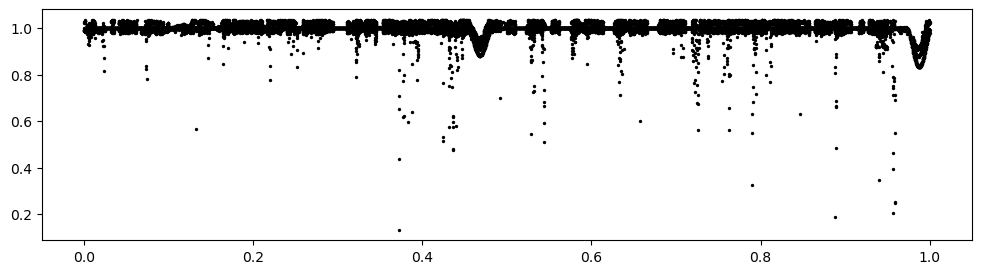

9


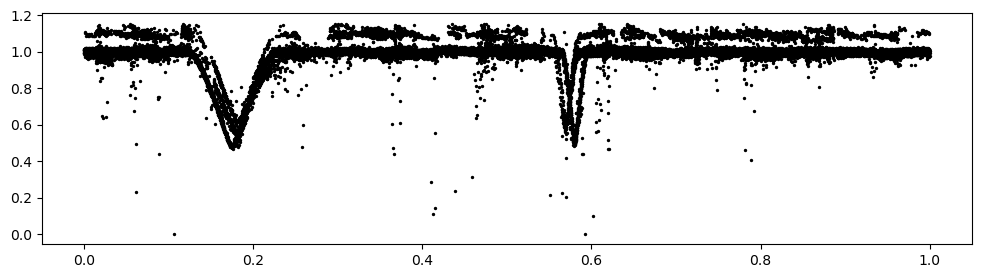

10


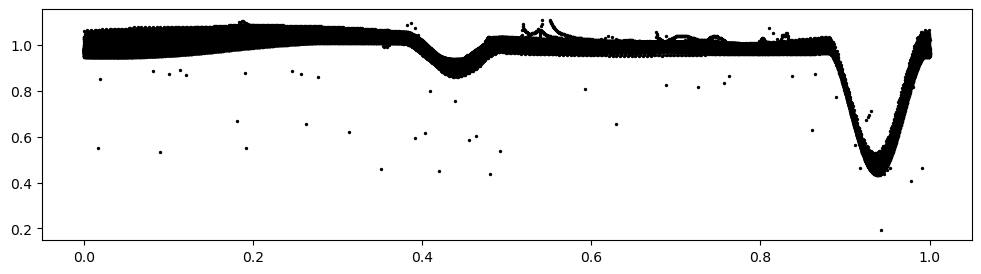

11


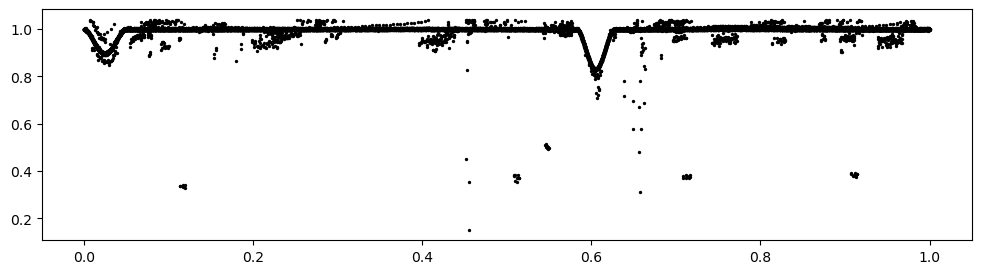

12


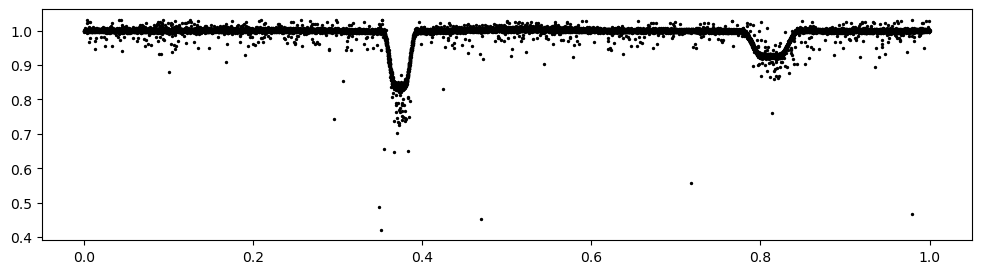

13


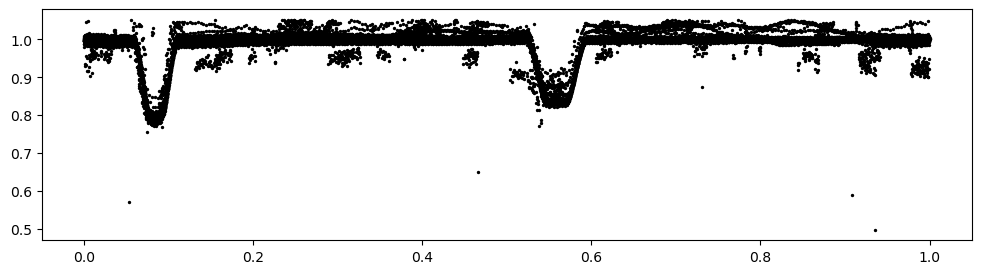

14


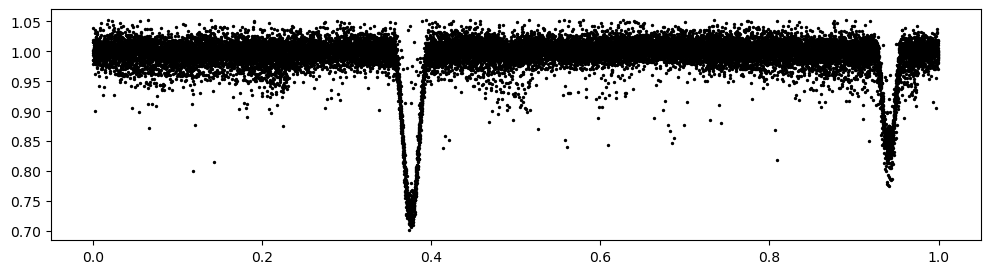

15


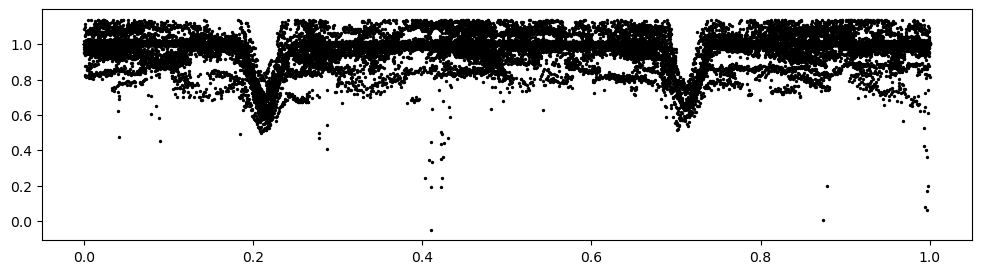

16


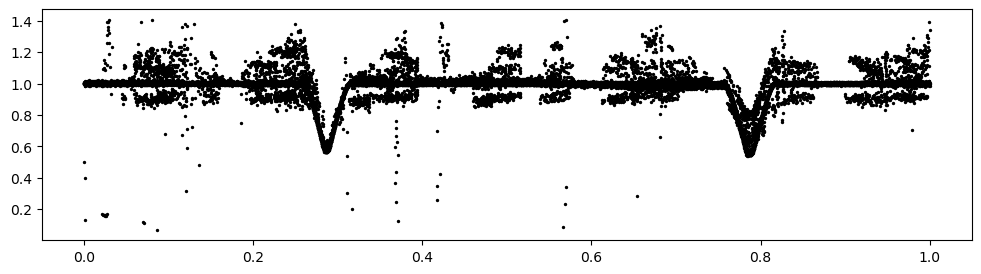

17


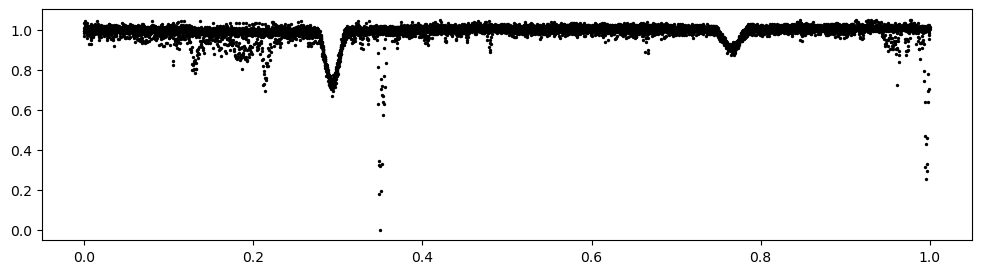

18


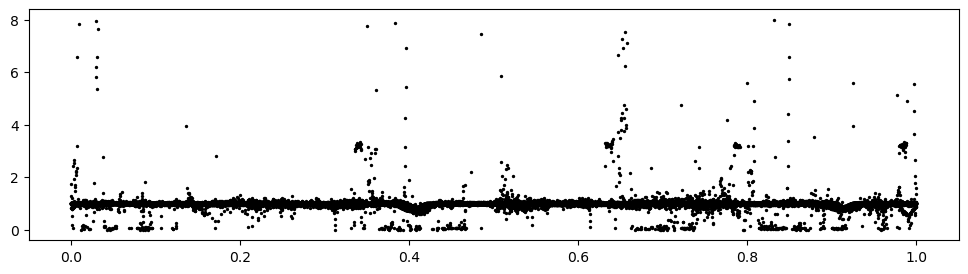

19


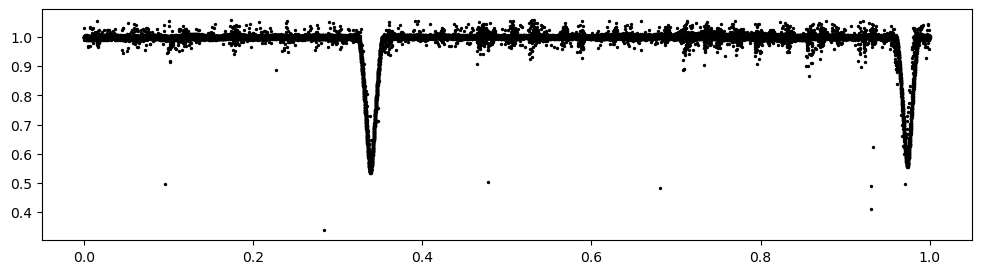

20


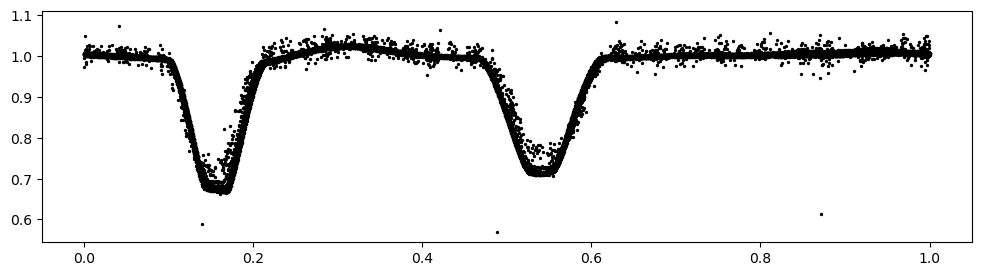

21


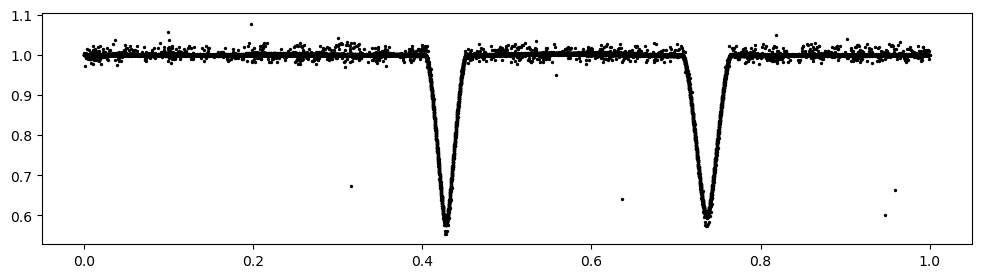

22


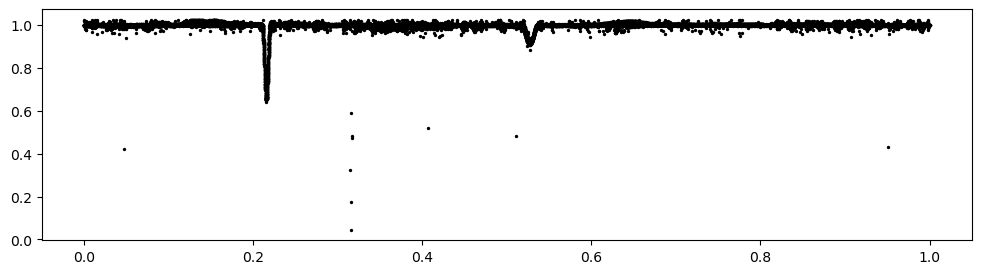

23


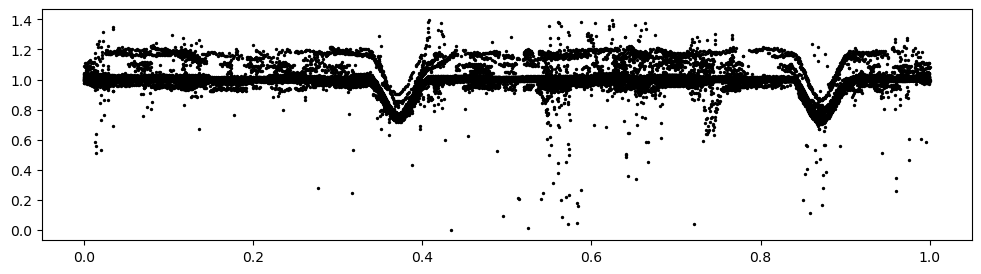

24


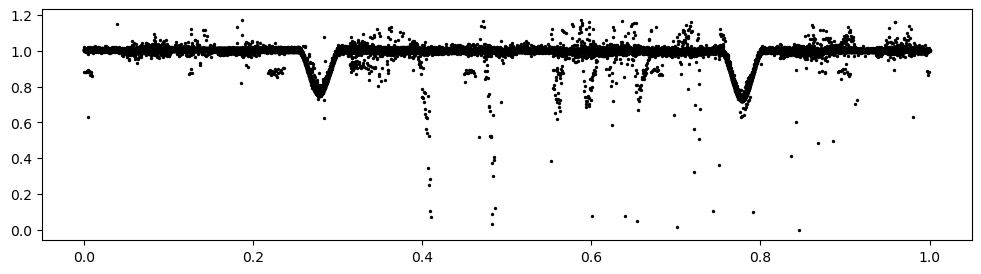

In [17]:
%matplotlib inline # Makes our plots interactive
# Visualise our phase folded lightcurves
for i, lc in enumerate(lightcurves_tess):
    print(i)
    plt.figure(figsize = (12,3))
    plt.scatter(lc['p_phase'], lc['flux'], s = 2, c = 'black')
    plt.show()

In [5]:
class TransitPicker: # Plot a lightcurve and allow the plotting of a start and end line.
    
    def __init__(self, time, flux):
        self.time = np.asarray(time)
        self.flux = np.asarray(flux)

        self.fig, self.ax = plt.subplots(figsize=(8, 4))
        self.ax.plot(self.time, self.flux, '.', ms=2, alpha=0.6)
        self.ax.set_xlabel("Phase")
        self.ax.set_ylabel("Flux")
        self.ax.set_title("Zoom, then click start and end of transit")
        self.ax.grid()

        self.click_times = []
        self.lines = []

        self.cid = self.fig.canvas.mpl_connect(
            'button_press_event', self.onclick
        )

    def onclick(self, event):
        # Ignore clicks outside axes
        if event.inaxes != self.ax:
            return
        
        # Ignore clicks if toolbar is in pan/zoom mode
        if self.fig.canvas.toolbar.mode != '':
            return
    
        # Record click
        self.click_times.append(event.xdata)
        line = self.ax.axvline(event.xdata, color='red', ls='--', lw=1.5)
        self.lines.append(line)
        self.fig.canvas.draw_idle()
    
        if len(self.click_times) == 2: # Only allow 2 clicks, the eclipse start and end
            t_start, t_end = self.click_times
            print(f"Transit start: {t_start:.6f}")
            print(f"Transit end:   {t_end:.6f}")
            print(f"Duration:      {t_end - t_start:.6f}")
            self.fig.canvas.mpl_disconnect(self.cid)


In [7]:
def lowess_model(phase, flux, frac=0.15,ngrid=200): # Fit a LOWESS model to our eclipses
    
    # Fit the LOWESS function
    lowess_xy = lowess(flux, phase, frac=frac, return_sorted=True)

    phase_lw = lowess_xy[:, 0]
    flux_lw = lowess_xy[:, 1]

    # Interpolate the values over an equally spaced grid
    phase_grid = np.linspace(phase_lw.min(), phase_lw.max(), ngrid)
    flux_grid = np.interp(phase_grid, phase_lw, flux_lw)

    return phase_grid, flux_grid

In [8]:
def fit_eclipse_model(lc, start_phase, end_phase, plot=True, primary=True): # Fit a model based on a start and endpoint

    # Get the widths of the eclipse out
    width_phase = end_phase - start_phase

    # Used for plotting and width calculation
    if primary == True:
        period = lc[0]['p_period']
        colour = 'blue'
    else:
        period = lc[0]['s_period']
        colour = 'red'

    # Convert width to units of time
    width = width_phase * period
    
    # Mask our eclipses
    if primary == True:
        ecl_mask = (lc['p_phase'] > start_phase) & (lc['p_phase'] < end_phase)
        phase = lc['p_phase'][ecl_mask]
    else:
        ecl_mask = (lc['s_phase'] > start_phase) & (lc['s_phase'] < end_phase)
        phase = lc['s_phase'][ecl_mask]

    flux = lc['flux'][ecl_mask]
    
    # Find midpoints to fold over --> Not robust
    mid_phase = 0.5 * (start_phase + end_phase)

    # Fold phase over midpoint
    phase_folded = phase - mid_phase
    
    # Reorder the phase and flux arrays
    order = np.argsort(phase_folded)
    phase_folded = phase_folded[order]
    flux_folded = flux[order]

    # Fit with a LOWESS function
    lowess_phase, lowess_flux = lowess_model(phase_folded, flux_folded)

    # Interpolate our function
    f = interp1d(lowess_phase, lowess_flux, bounds_error=False, fill_value="extrapolate")

    xmax = np.nanmax(np.abs(phase_folded))
    x = np.linspace(0, xmax, 200)

    # Average our left and right side to ensure symmetry
    flux_sym_half = 0.5 * (f(x) + f(-x))
    
    phase_sym = np.concatenate([-x[::-1], x])
    flux_sym  = np.concatenate([flux_sym_half[::-1], flux_sym_half])

    # Clip to ensure all values are at or below one
    model = np.clip(flux_sym, 0, 1)

    if plot == True: # Visualise the model fit

        plt.close('all')
        plt.scatter(phase_folded, flux_folded, c = 'black', s = 3, label = 'Data')
        plt.plot(phase_sym, model, c = colour, label = 'LOWESS Fit')
        plt.xlabel('Phase')
        plt.ylabel('Flux')
        plt.title('Phase folded eclipse')
        plt.ylim(min(model) - 0.1, 1.1)
        plt.legend()
        plt.grid()
        plt.show()
        
    return model, width

In [9]:
# Choose a lightcurve we want to model
lc = lightcurves_tess[0]

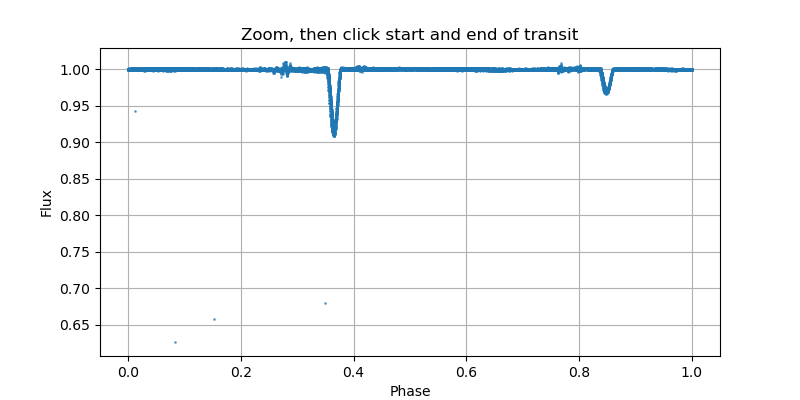

In [10]:
# Mask the primary eclipse
plt.close('all')
picker = TransitPicker(lc['p_phase'], lc['flux'])

In [11]:
# Extract the start and end phases for our primary eclipse
p_start_phase, p_end_phase = picker.click_times

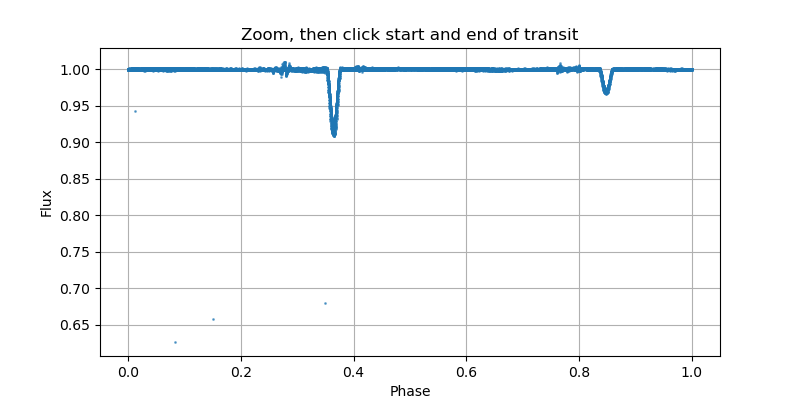

In [12]:
# Repeat with the secondary
plt.close('all')
picker = TransitPicker(lc['s_phase'], lc['flux'])

In [13]:
# Markers for the secondary eclipse
s_start_phase, s_end_phase = picker.click_times

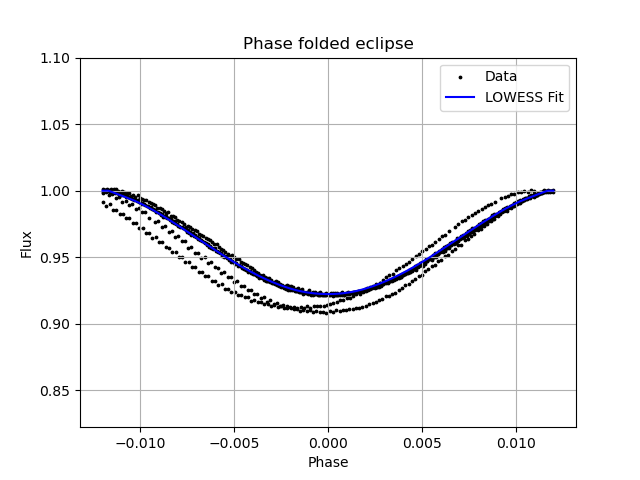

In [16]:
# Fit our primary eclipse model
p_model, p_width = fit_eclipse_model(lc, p_start_phase, p_end_phase)

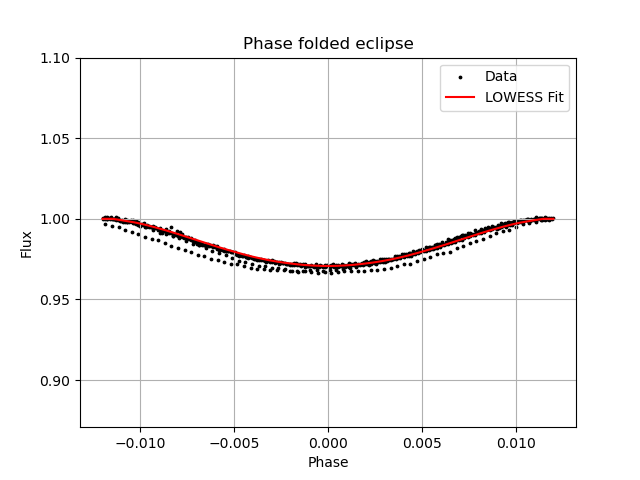

In [15]:
# Fit and plot our secondary
s_model, s_width = fit_eclipse_model(lc, s_start_phase, s_end_phase, primary=False)

On top of making models of the eclipse, we also need to find mid eclipse times as a reference point. These just let us define a window where we expect our eclipse to be so we know where to search later. As such, getting these exact isn't very important, as long as they roughly mark the eclipse location. We can use the same picker function in the time domain to mask out a single eclipse, and then fit a spline to find the lowest point in the eclipse. In reality, this is unnecessarily complicated. Simply taking the minimum flux within a window containing only the eclipse would be sufficient.

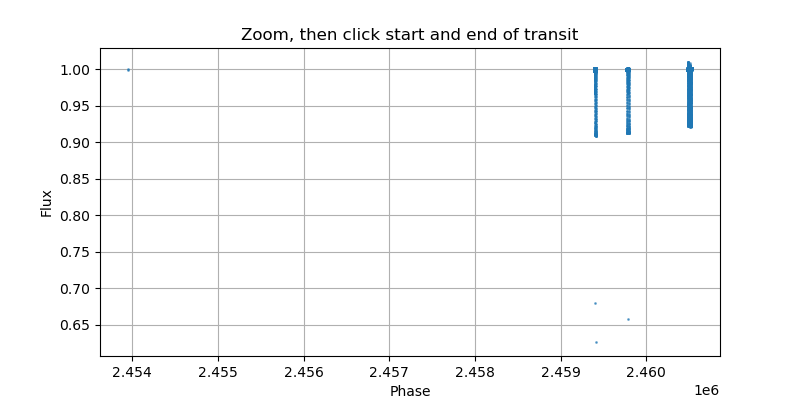

In [17]:
# Select a reference primary eclipse
plt.close('all')
picker = TransitPicker(lc['time'], lc['flux'])

In [18]:
# Extract the times from the primary
t_start_p, t_end_p = picker.click_times

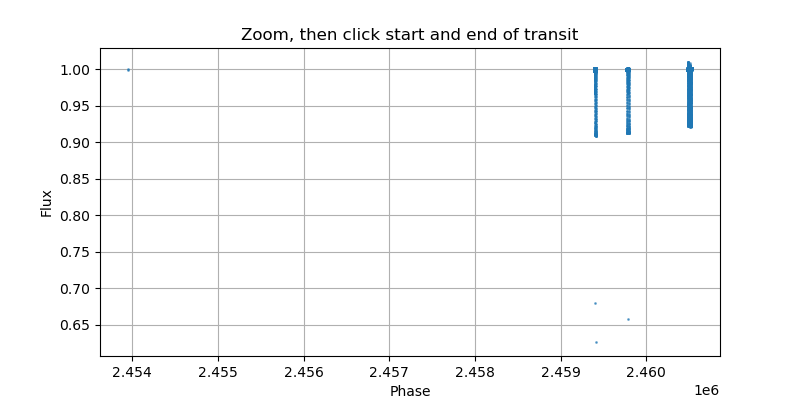

In [19]:
# Repeat with the secondary
plt.close('all')
picker = TransitPicker(lc['time'], lc['flux'])

In [20]:
# Extract times
t_start_s, t_end_s = picker.click_times

In [1]:
def find_initial_mets(lc, t_start_p, t_end_p, t_start_s, t_end_s, plot=True): # Find primary and secondary mid eclipse times based on the masks

    # Create eclipse masks
    p_ecl_mask = (lc['time'] > t_start_p) & (lc['time'] < t_end_p)
    s_ecl_mask = (lc['time'] > t_start_s) & (lc['time'] < t_end_s)
    
    # Mask and interpolate our reference eclipses
    time_p = lc[p_ecl_mask]['time']
    flux_p = lc[p_ecl_mask]['flux']
    
    time_s = lc[s_ecl_mask]['time']
    flux_s = lc[s_ecl_mask]['flux']
    
    t_grid_p = np.linspace(min(time_p), max(time_p), len(time_p))
    flux_interp_p = interp1d(time_p, flux_p, kind='cubic')(t_grid_p)
    
    t_grid_s = np.linspace(min(time_s), max(time_s), len(time_s))
    flux_interp_s = interp1d(time_s, flux_s, kind='cubic')(t_grid_s)
    
    # Spline fit our reference eclipses
    spline_p = UnivariateSpline(t_grid_p, flux_interp_p, s=0.001)  
    model_p = spline_p(t_grid_p)
    
    spline_s = UnivariateSpline(t_grid_s, flux_interp_s, s=0.001)  
    model_s = spline_s(t_grid_s)
    
    # Find the METs of our reference eclipses
    met_idx_p = np.argmin(model_p)
    met_idx_s = np.argmin(model_s)
    
    met_p = t_grid_p[met_idx_p]
    met_s = t_grid_s[met_idx_s]

    if plot == True:
        # Plot our results to make sure they look as intended.
        plt.close('all')
        plt.figure(figsize = (12,3))
        plt.plot(t_grid_p, model_p, c = 'blue', label = 'Primary')
        plt.plot(t_grid_s, model_s, c = 'red', label = 'Secondary')
        plt.axvline(met_p, ls = '--', c = 'blue')
        plt.axvline(met_s, ls = '--', c = 'red')
        plt.show()

    return met_p, met_s

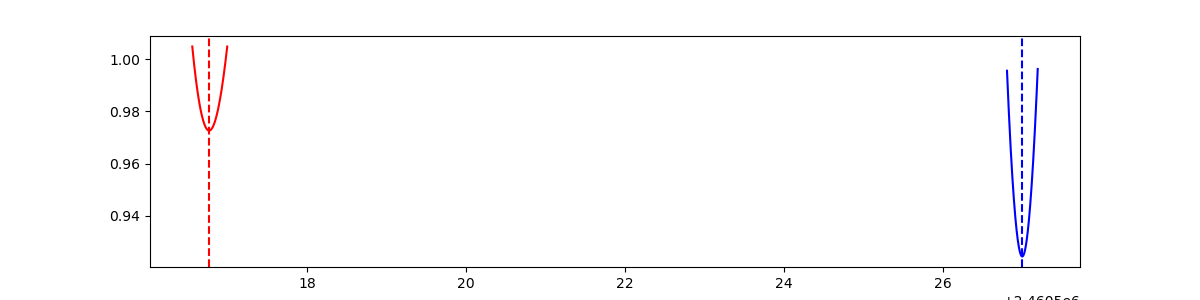

In [22]:
# Calculate the initial mid eclipse times
met_p, met_s = find_initial_mets(lc, t_start_p, t_end_p, t_start_s, t_end_s)

Note sometimes it is difficult to get a clean model for an eclipse from the phase folded lightcurves due to high levels of noise, artifacts, changes in the period over time, or other reasons. In such cases, we just fit the model on the time domain by selecting a single eclipse. This is just a fallback method, as it will implicitly introduce noise into our model. The function below is used to fit models in the time domain.

In [2]:
# This is pretty much identical with the variables changed from phase --> time
def fit_eclipse_model_time_domain(lc, start_time, end_time, plot=True, primary=True): 

    if primary == True:
        colour = 'blue'
        period = lc['p_period'][0]
    else:
        colour = 'red'
        period = lc['s_period'][0]

    # Mask our eclipses
    ecl_mask = (lc['time'] > start_time) & (lc['time'] < end_time)
    time = lc['time'][ecl_mask]
    flux = lc['flux'][ecl_mask]
    
    # Find midpoints to fold over
    mid_time = 0.5 * (start_time + end_time)

    # Fold time over midpoint
    time_folded = time - mid_time
    
    # Reorder the time and flux arrays
    order = np.argsort(time_folded)
    time_folded = time_folded[order]
    flux_folded = flux[order]

    # Fit with a LOWESS function
    lowess_time, lowess_flux = lowess_model(time_folded, flux_folded)

    f = interp1d(lowess_time, lowess_flux, bounds_error=False, fill_value="extrapolate")

    xmax = np.nanmax(np.abs(time_folded))
    x = np.linspace(0, xmax, 200)

    flux_sym_half = 0.5 * (f(x) + f(-x))
    
    time_sym = np.concatenate([-x[::-1], x])
    flux_sym  = np.concatenate([flux_sym_half[::-1], flux_sym_half])

    # Clip to ensure all values are at or below one
    model = np.clip(flux_sym, 0, 1)

    # Calculate the width (easier in just time space)
    width = end_time - start_time

    if plot == True:

        plt.close('all')
        plt.scatter(time_folded, flux_folded, c = 'black', s = 3, label = 'Data')
        plt.plot(time_sym, model, c = colour, label = 'LOWESS Fit')
        plt.xlabel('Phase')
        plt.ylabel('Flux')
        plt.title('Phase folded eclipse')
        plt.ylim(min(model) - 0.1, 1.1)
        plt.legend()
        plt.grid()
        plt.show()
        
    return model, width

Once we have a model, width, and timing for both the primary and secondary, we can save this data to a csv file. This code is commented out for now since the csv file with the data already exists and doesn't need to be remade.

In [25]:
# # File to save results
# output_file = "Data/eclipse_models.csv"

# model_len = 400  # Adjust to the size of your models

# # Create the file if it doesnt exist
# if not os.path.exists(output_file):
#     primary_cols   = [f'primary_model_{i}' for i in range(model_len)]
#     secondary_cols = [f'secondary_model_{i}' for i in range(model_len)]

#     all_cols = (primary_cols + secondary_cols + ['primary_met', 'secondary_met','primary_width', 'secondary_width'])
#     df_init = pd.DataFrame(columns=all_cols)
#     df_init.to_csv(output_file, index=False)

# # Format and append the necessary data row by row
# row_data = np.concatenate([p_model, s_model, [met_p, met_s, p_width, s_width]])
# df = pd.DataFrame([row_data], columns=pd.read_csv(output_file, nrows=0).columns)
# df.to_csv(output_file, mode='a', index=False, header=False)


In [26]:
# Here is code to remove the last row in case you accidentally append a duplicate or bad model
# df = pd.read_csv("eclipse_models.csv")

# # Drop the last row
# df = df.iloc[:-1]

# # Save it back
# df.to_csv("eclipse_models.csv", index=False)

Once we have created our models and taken note of the width/time of the eclipses, we can start calculating our mid eclipse times, which is what is done in the last notebook.